In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [24]:
import cv2
import keras
from keras import optimizers

import config
import metrics
from generator import CamVidFlowGenerator
from generator.base_generator import one_hot_to_bgr
from models import SegNetWarp, SegNet
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


target_size = 288, 480
is_debug = True
datagen = CamVidFlowGenerator(config.data_path())

modelWarp = SegNetWarp(target_size, datagen.n_classes, is_debug=is_debug)
modelWarp.k.load_weights('checkpoint/debug/SegNetWarp_save_epoch.h5')
modelWarp.k.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
    metrics=[
        metrics.dice_coef,
        metrics.precision,
        keras.metrics.categorical_accuracy,
        metrics.mean_iou
    ],
)

model = SegNet(target_size, datagen.n_classes, is_debug=is_debug)
model.k.load_weights('checkpoint/debug/SegNet_save_epoch.h5')   
model.k.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
    metrics=[
        metrics.dice_coef,
        metrics.precision,
        keras.metrics.categorical_accuracy,
        metrics.mean_iou
    ],
)

   

/home/mlyko/data/camvid/
CamVid: train 574 files
CamVid: val 123 files
CamVid: test 0 files
training samples 574, validating samples 123, test samples 0


In [19]:
    print(model.k.metrics_names)
    evaluation = modelWarp.k.evaluate_generator(datagen.flow('val', 5, target_size), 
                                            steps=datagen.steps_per_epoch('val', 5)
                                           )
    
    print(evaluation)

/home/mlyko/data/camvid/
CamVid: train 574 files
CamVid: val 123 files
CamVid: test 0 files
training samples 574, validating samples 123, test samples 0
[2.7068894577026366, 0.2947119152545929, 0.4215556037425995, 0.3788030672073364, 0.3788030672073364]


['loss', 'dice_coef', 'precision', 'categorical_accuracy', 'mean_iou']


1/1 [==============================] - 3s 3s/step


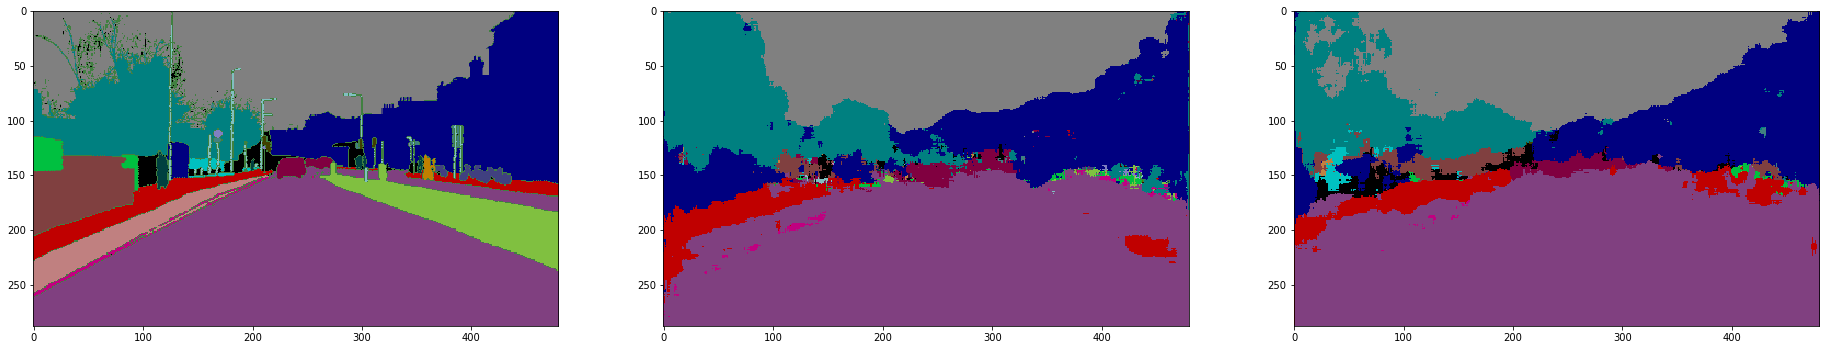

In [35]:
#f, arr = plt.subplots(1, 3)
f.set_size_inches(15, 15)

fig = plt.figure(figsize=(32,32))

i = 0
n = 2*3
for imgBatch, gtBatch in datagen.flow('train', 1, target_size):
    imgOld = imgBatch[0]
    imgNew = imgBatch[1]
    flow = imgBatch[2]
    gt = gtBatch[0]
#        print(imgOld.shape, imgNew.shape, flow.shape, gt.shape)

    colored_class_image = one_hot_to_bgr(gt, target_size, datagen.n_classes, datagen.labels)
    
    predicted = one_hot_to_bgr(model.k.predict(imgNew, 1, verbose=1), target_size, datagen.n_classes, datagen.labels)

    predictedWarp = one_hot_to_bgr(modelWarp.k.predict(imgBatch, 1, verbose=1), target_size, datagen.n_classes, datagen.labels)
    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(colored_class_image)
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(predicted)

    ax = fig.add_subplot(1,3,3)
    ax.imshow(predictedWarp)    
  

    i += 1

    
    if i > 2:
        break